<a href="https://colab.research.google.com/github/brahma2024/Deep-Implicit-Layers/blob/main/NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 3: Neural ODE**

- Define MLP, ResNet, loss function and training from scratch
- Add ODE
- Batch ODE
- Solve a curve fitting with ODENet and compare with from scratch ResNet

In [ ]:
!pip install torchdiffeq
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Step 1: Define an MLP**

In [ ]:
# Define an MLP

class CustomMLPBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomMLPBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  # Linear layer
        self.bn = nn.BatchNorm1d(output_size)         # Batch normalization
        self.activation = nn.Tanh()            # Tanh activation

    def forward(self, x):
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out

In [ ]:
# Instantiate and test the block
block = CustomMLPBlock(input_size=10, output_size=5)
inputs = torch.randn(3, 10, requires_grad=True)  # Sample input
outputs = block(inputs)
loss = outputs.sum()  # Simple loss
loss.backward()  # Backward pass
print(loss)

tensor(0.0814, grad_fn=<SumBackward0>)


**Step 2: Define a ResNet**

In [ ]:
# To build larger models, chain together or compose layers
class ResidualBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResidualBlock, self).__init__()
        self.mlp = CustomMLPBlock(input_size, output_size)

        # If input and output sizes differ, apply a linear transformation to the input to match sizes
        self.match_dimensions = nn.Linear(input_size, output_size) if input_size != output_size else None

    def forward(self, x):
        residual = x
        out = self.mlp(x)

        # If dimensions don't match, transform the input to match the output size
        if self.match_dimensions:
            residual = self.match_dimensions(x)

        out = out + residual  # Add the input (identity connection) to the output
        return out


**Step 3: Build a Deep ResNet-like Model**

In [ ]:
class DeepResNet(nn.Module):
    def __init__(self, input_size, num_blocks, block_size=64, output_size=1):
        super(DeepResNet, self).__init__()
        self.input_layer = nn.Linear(input_size, block_size)
        # block_size refers to the number of neurons (or units) in each layer of the residual blocks
        self.blocks = nn.Sequential(*[ResidualBlock(block_size, block_size) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(block_size, output_size)

    def forward(self, x):
      print(f'input step: {x.shape=}')
      out = self.input_layer(x)
      print(f'1st layer out: {out.shape=}')
      out = self.blocks(out)
      print(f'2nd layer out: {out.shape=}')
      out = self.output_layer(out)
      print(f'3rd layer out: {out.shape=}')
      return out

**Step 4: Define the Model, Loss Criterion, Optimizer**

In [ ]:
# Define Toy Dataset
inputs = torch.tensor(np.linspace(-4, 4, 40), dtype=torch.float32).reshape(-1, 1)
print(f'{inputs.shape=}')
# Generate random noise (from normal distribution)
# noise = torch.tensor(np.linspace(-4, 1, 20), dtype=torch.float32).reshape(-1, 1)

# Add noise to the inputs
# noisy_inputs = inputs

# Targets
targets = torch.tensor(inputs**3 + 0.1*inputs, dtype=torch.float32)  # Cubic relationship
print(f'{targets.shape=}')
# Parameters
input_size = 1  # For 1D inputs
num_blocks = 1  # Number of residual blocks in the ResNet
block_size = 20  # Number of neurons in each layer
output_size = 1  # Single output for curve fitting

# Instantiate the model
model = DeepResNet(input_size, num_blocks, block_size, output_size)

# Convert model to double precision (float32)
model = model.float()

# Convert model to double precision (float64)
# model = model.double()

# Define loss function and optimizer
criterion = nn.MSELoss()


inputs.shape=torch.Size([40, 1])
targets.shape=torch.Size([40, 1])


<ipython-input-24-a3b4276b4a6e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(inputs**3 + 0.1*inputs, dtype=torch.float32)  # Cubic relationship


**Step 5: Train the model on a Toy 1D dataset**

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    # print(f'{outputs.shape=}')

    # Calculate loss
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss at intervals
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, the model should have learned the cubic relationship

input step: x.shape=torch.Size([40, 1])
1st layer out: out.shape=torch.Size([40, 20])
2nd layer out: out.shape=torch.Size([40, 20])
3rd layer out: out.shape=torch.Size([40, 1])


**Step 5.5: Save Model Parameters**

In [ ]:
# Assuming `model` trained model
torch.save(model.state_dict(), 'model_parameters.pth')

In [ ]:
# Assuming `model` is an instance of the model class
model = DeepResNet(input_size, num_blocks, block_size, output_size)  # Re-create the model instance

# Load the state_dict (parameters)
model.load_state_dict(torch.load('model_parameters.pth'))

<ipython-input-11-46307ab36677>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_parameters.pth'))


<All keys matched successfully>

**Step 6: Make Predictions, and plot the results**

In [ ]:
# Generate fine inputs for predictions
fine_inputs = torch.tensor(np.linspace(-3, 3, 10), dtype=torch.float32).reshape(-1, 1)

# Set the model to evaluation mode for inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(fine_inputs)

# Convert tensors to NumPy arrays for plotting
inputs_np = inputs.numpy()
targets_np = targets.numpy()
fine_inputs_np = fine_inputs.numpy()
predictions_np = predictions.numpy()


fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot()
ax.scatter(inputs_np, targets_np, lw=0.5, color='green')
ax.plot(fine_inputs_np, predictions_np, lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')


NameError: name 'noisy_inputs' is not defined

**Step 7: [Optional] Reading/Viewing Model Parameters**

In [ ]:
# Load the state_dict from the .pth file
state_dict = torch.load('model_parameters.pth')

# Print the keys of the state_dict to see the names of the layers
print("Keys in state_dict:")
print(state_dict.keys())

# Print out the actual values for one of the layers (e.g., the weights of the first layer)
for key, value in state_dict.items():
    print(f"\nLayer: {key}")
    print(value)

# **Neural ODE (ODE-Net)**

the key idea is to model the continuous transformation of data using an ordinary differential equation (ODE). Instead of stacking discrete layers as in a traditional neural network, the model learns the dynamics of the data over time, which are then integrated using an ODE solver.

Key Components:
Dynamics Function: This function specifies how the state of the system changes over time. In a neural ODE, this is modeled by a neural network.
ODE Solver: This numerically integrates the dynamics over a time interval to predict the system's behavior at future times.

**Step 1: Import ODEINT and ODEINT_ADJOINT Functions**

In [ ]:
from torchdiffeq import odeint, odeint_adjoint
from functorch import vmap

**Step 2: Define the Batched Dynamics Function**

In [ ]:
class BatchedDynamicsFunction(nn.Module):
  def __init__(self, hidden_size):
    super(BatchedDynamicsFunction, self).__init__()
    self.fc1 = nn.Linear(hidden_size + 1, hidden_size)  # +1 for time
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)

  def forward(self, t, state):
    # print(f'dynamicsFunc_state {state.shape=}')
    batch_size, hidden_size = state.shape  # Get batch size and hidden state size from input state
    # print(f'{batch_size=}, {hidden_size=}')

    time = t.unsqueeze(0).unsqueeze(-1).expand(batch_size, 1)  # Shape [batch_size, 1]
    # print(f'{time.shape=}')

    # Concatenate state and time along the last dimension
    state_and_time = torch.cat([state, time], dim=-1)  # Shape: [batch_size, hidden_size + 1]
    # print(f'{state_and_time.shape=}')

    out = torch.tanh(self.fc1(state_and_time))
    out = torch.tanh(self.fc2(out))
    out = self.fc3(out)
    return out

**Step 2: ODE Solver**

In [ ]:
class BatchedODEBlock(nn.Module):
  def __init__(self, dynamics_function, window_size):
    super(BatchedODEBlock, self).__init__()
    self.dynamics_function = dynamics_function
    self.time_steps = window_size

  def forward(self, initial_state):
    # print(f'BatchedODEBlock_inputstate {initial_state.shape=}')

    # Define the time interval to span the entire window (e.g., 10 time steps)
    time_interval = torch.arange(0, self.time_steps, dtype=torch.float32)  # Shape: [10]

    # Solve ODE for the initial state across the time interval
    # odeint expects shape [batch_size, state_size], so input_state should be [batch_size, hidden_size]
    out = odeint(self.dynamics_function, initial_state, time_interval, method='dopri5')

    # We can return either the final state or the entire trajectory, depending on the use case.
    # Here, we return the final state after integration
    return out[-1]  # Shape: [batch_size, hidden_size]

**Step 3: Chain the ODEBlock**

In [ ]:
# Define your model structure
class BatchedODENet(nn.Module):
  def __init__(self, state_size, hidden_size, window_size):
    super(BatchedODENet, self).__init__()
    self.input_layer = nn.Linear(state_size, hidden_size)
    self.ode_block = BatchedODEBlock(BatchedDynamicsFunction(hidden_size), window_size)
    self.output_layer = nn.Linear(hidden_size, state_size)

  def forward(self, x):
    # print(f'input {x.shape=}')
    x = torch.tanh(self.input_layer(x))
    # print(f'odeblock_input {x.shape=}')

    # Only pass the initial state (first time step) of each batch to ode_block
    initial_state = x[:, 0, :]  # Shape: [batch_size, hidden_size]
    # print(f'initial_state {initial_state.shape=}')

    # Integrate the initial state forward across the time interval
    x = self.ode_block(initial_state)
    # print(f'odeblock_output {x.shape=}')

    x = self.output_layer(x)
    return x

**Steps: for Batched Neural ODE in PyTorch:**

Modify the Dynamics Function to handle batched inputs.
Integrate with ODE Solver in a batched fashion by solving for all batch elements simultaneously.
Train the model using a typical batch-based gradient descent method.

**Sliding Window Concept**
Given a time series of stock prices over the last 6 months, let's assume we have 180 daily closing prices,

{$𝑥_1, 𝑥_2, …,𝑥_{180}$}

The goal is to use a sliding window to create overlapping segments of this time series, each segment representing a small window of consecutive prices.

For a window size of 10 days, the sliding window would generate the following sequences:

$$
X_1 = \{ x_1, x_2, \dots, x_{10} \}, \\
X_2 = \{ x_2, x_3, \dots, x_{11} \}, \\
\vdots \\
X_{171} = \{ x_{171}, x_{172}, \dots, x_{180} \}.
$$

Here, each $𝑋_𝑖$ is a 10-dimensional vector representing 10 consecutive days of stock prices.

Using a stochastic process like `Geometric Brownian Motion (GBM)`, to model stock prices

In [ ]:
# Parameters for the GBM model
S0 = 55.0  # Initial stock price
mu = 0.05   # Expected return
sigma = 0.4 # Volatility
T = 1.0     # Time horizon
N = 252     # Number of time steps (e.g., trading days in a year)
dt = T / N  # Time step size

# Generate random normal variables for the Brownian motion
z = torch.randn(N)

# Convert dt to a tensor
dt_tensor = torch.tensor(dt, dtype=torch.float32)

# Simulate stock prices using GBM
def simulate_gbm(S0, mu, sigma, dt_tensor, z):
    S = torch.zeros(len(z) + 1)
    S[0] = S0
    for t in range(1, len(S)):
        S[t] = S[t-1] * torch.exp((mu - 0.5 * sigma**2) * dt_tensor + sigma * torch.sqrt(dt_tensor) * z[t-1])
    return S

# Generate the simulated prices
prices = simulate_gbm(S0, mu, sigma, dt_tensor, z)
print(f'{prices.shape=}, {len(prices)=}, {prices=}')

prices.shape=torch.Size([253]), len(prices)=253, prices=tensor([55.0000, 56.9702, 57.4069, 57.2471, 56.2790, 56.8320, 55.2449, 56.2978,
        54.3865, 54.2178, 55.5135, 56.1347, 55.8590, 56.8322, 57.4726, 56.8909,
        56.7270, 57.1388, 58.5935, 56.8580, 57.6819, 55.9749, 57.5737, 60.9535,
        64.8523, 66.2642, 69.0800, 66.1451, 65.9249, 65.9805, 67.0559, 70.4720,
        69.7736, 68.9730, 71.4295, 69.4464, 64.7717, 64.9055, 64.4862, 65.7970,
        63.9955, 64.6272, 63.0489, 64.7788, 64.6500, 64.0811, 63.2136, 64.4543,
        63.1575, 63.3444, 63.1333, 64.2682, 64.3236, 65.3465, 63.8727, 64.3728,
        64.0395, 65.6848, 66.3200, 66.9975, 67.9128, 68.3168, 71.3728, 72.4362,
        75.0944, 74.8898, 74.6737, 75.2464, 74.7058, 77.1593, 74.4598, 73.8811,
        74.8200, 71.9846, 72.2362, 72.9213, 70.9071, 70.5718, 71.7610, 70.0825,
        71.1025, 70.6620, 72.0822, 71.5649, 71.3289, 73.0817, 75.1169, 74.9274,
        73.7972, 73.2976, 74.9075, 75.0399, 77.4943, 78.5904, 77

In [ ]:
prices = prices.view(-1, 1)
print(f'{prices.shape=}')
print(prices[:10])

prices.shape=torch.Size([253, 1])
tensor([[55.0000],
        [56.9702],
        [57.4069],
        [57.2471],
        [56.2790],
        [56.8320],
        [55.2449],
        [56.2978],
        [54.3865],
        [54.2178]])


In [ ]:
# Simulated stock prices for 40 days
# prices = torch.tensor(np.linspace(-4, 4, 40), dtype=torch.float32).reshape(-1, 1)
print(f'{prices.shape=}')
# Define the window size
window_size = 10

# Create sliding windows
windows = [prices[i:i+window_size] for i in range(len(prices) - window_size + 1)]
batched_inputs = torch.stack(windows)  # Shape: [price.shape - window_size+1, window_size, 1]
print(f'{batched_inputs.shape=}')

prices.shape=torch.Size([253, 1])
batched_inputs.shape=torch.Size([244, 10, 1])


In [ ]:
# Assuming a previously defined BatchedODENet model
model = BatchedODENet(state_size=1, hidden_size=64, window_size=window_size)  # Example sizes

# Define a simple loss function based on returns (example)
def loss_fn(predicted, target):
  return torch.mean((predicted - target) ** 2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(1000):  # Example epoch count
  optimizer.zero_grad()

  # Forward pass through the model
  predictions = model(batched_inputs)
  # predictions_for_loss_comparison = predictions[:, -1, :]
  # print(f'{predictions.shape=}, {predictions_for_loss_comparison.shape=}')
  target_returns = batched_inputs[:, -1, :]  # Assuming the target is the price of the last day in each window

  # Compute loss
  loss = loss_fn(predictions, target_returns)
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print('------------------------------------------')
    print(f"Epoch {epoch}, Loss: {loss.item()}")
    print(f' {predictions[0, :]=} | {target_returns[0, :]=}')

------------------------------------------
Epoch 0, Loss: 22.398239135742188
 predictions[0, :]=tensor([60.6732], grad_fn=<SliceBackward0>) | target_returns[0, :]=tensor([54.2178])
------------------------------------------
Epoch 100, Loss: 21.566707611083984
 predictions[0, :]=tensor([59.0135], grad_fn=<SliceBackward0>) | target_returns[0, :]=tensor([54.2178])
------------------------------------------
Epoch 200, Loss: 21.508665084838867
 predictions[0, :]=tensor([58.7047], grad_fn=<SliceBackward0>) | target_returns[0, :]=tensor([54.2178])
------------------------------------------
Epoch 300, Loss: 21.474525451660156
 predictions[0, :]=tensor([58.6955], grad_fn=<SliceBackward0>) | target_returns[0, :]=tensor([54.2178])
------------------------------------------
Epoch 400, Loss: 21.434894561767578
 predictions[0, :]=tensor([58.6961], grad_fn=<SliceBackward0>) | target_returns[0, :]=tensor([54.2178])
------------------------------------------
Epoch 500, Loss: 21.386873245239258
 predict

In [ ]:
loss

tensor(21.2907, grad_fn=<MeanBackward0>)

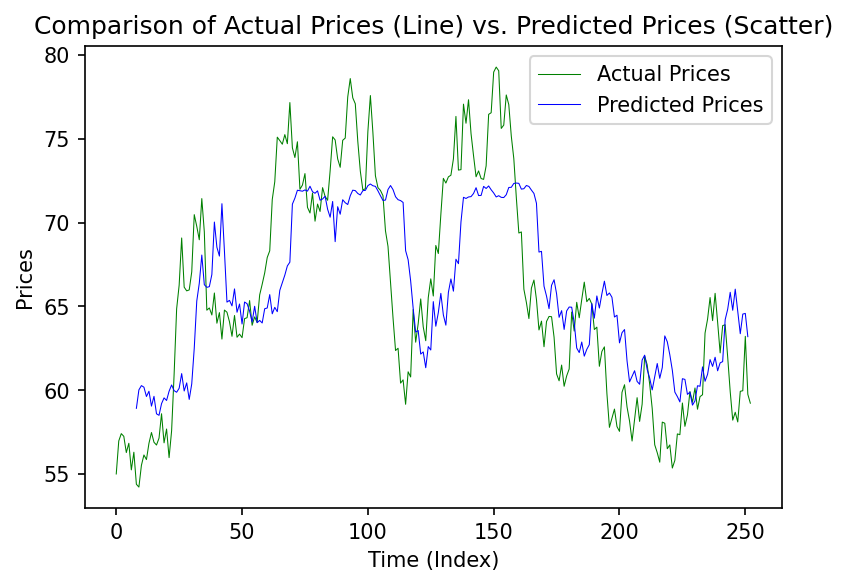

In [ ]:
# Convert tensors to NumPy arrays for plotting
prices_np = prices.detach().numpy()
predicted_prices_np = predictions.detach().numpy()

# Set the index where predicted prices start (9th time stamp)
start_index = 8

# Create an array of time points for the predicted prices (starts at 9th point in time)
time_points_for_predictions = np.arange(start_index, start_index + len(predicted_prices_np))

# Plot actual prices (x-axis) vs. predicted prices (y-axis)
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot()

# Line plot for all input prices
ax.plot(np.arange(len(prices_np)), prices_np, lw=0.5, color='green', label='Actual Prices')

# Scatter plot for predicted prices, starting from the 9th timestamp
ax.plot(time_points_for_predictions, predicted_prices_np, lw=0.5, color='blue', label='Predicted Prices')

# Set labels and title
ax.set_xlabel('Time (Index)')
ax.set_ylabel('Prices')
ax.set_title('Comparison of Actual Prices (Line) vs. Predicted Prices (Scatter)')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# Assuming `model` trained model
torch.save(model.state_dict(), 'NeuralODE_model_parameters.pth')

In [ ]:
# Assuming `model` is an instance of the model class
model_ODE = BatchedODENet(state_size=1, hidden_size=50, window_size=window_size)

# Load the state_dict (parameters)
model_ODE.load_state_dict(torch.load('NeuralODE_model_parameters.pth'))

<ipython-input-11-109301e35573>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ODE.load_state_dict(torch.load('NeuralODE_model_parameters.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'NeuralODE_model_parameters.pth'

next steps:
1. Implement CT-RNN on the above input data
2. Compare Neural ODEs and CT-RNN implementation in terms of their Expressivity
    3. A key measure of expressivity in time-continuous models is the trajectory length — how the trajectory of input data is transformed through the network layers
2.1. Backward pass with
    2.1.1. Adjoint vs Backpropagation through time: plot accuracy and memory requirements
2.1.2. Fused Euler Solver: apply to CT-RNN and Neural ODE, see how it performs    
4. Memory profiling for Neural ODE vs. CT-RNNs (small-Tau vs Large-Tau)
5. Adaptive dynamics in LTCs
6. Compare LTCs vs Neural ODEs and CT-RNNs in terms of memory



# Loss Function as Profit/Loss of the trade
- stock price at final state is y_T
- we need to maximize (y_T - buy_price)
- or say we have to minimize 1/(y_T - buy_price)